In [1]:
import datetime
import os
from typing import Tuple

import lightning as L
import matplotlib.pyplot as plt
import torch
import wandb
from pytorch_lightning.loggers import WandbLogger
from torch import nn

from shared import overwrite_args_cli
from shared.data_module import DataModule
from uncertainy.radio import get_radio_data_loaders
from uncertainy.toy_regression import get_toy_regression_data_loaders
from matplotlib.pyplot import scatter
import pandas as pd
import seaborn as sns

torch.set_float32_matmul_precision('medium')
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
h = {  # hyperparameters
    'ensemble_size': 3,
    'dataset': 'TOY_REGRESSION',  #'TOY_REGRESSION', 'RADIO',
    'dataset_path': '../data/',

    'in_channels': 2,
    'hidden_channels': 32,
    'epochs': 200,
    'learning_rate': 1e-3,
    'checkpoint_path': './saved_models',
    'batch_size': 32,
    'num_workers': 4,

    'limit_train_batches': 1.0,
    'limit_val_batches': 1.0,
    'limit_test_batches': 1.0,

    'use_wandb': False,
    'wandb_project': 'uncertainty',
    'wandb_entity': 'oBoii',
    'wandb_name': 'radio',

    'train': True,  # Set this to false if you only want to evaluate the model
    'fast_dev_run': False,
    'overfit_batches': 0.0
}

h = overwrite_args_cli(h)
# In terminal, run:
# python main.py --model SinkhornConvNetV2 --epochs 30

In [3]:
class SimpleNet(L.LightningModule):
    def __init__(self):
        super(SimpleNet, self).__init__()
        hidden_size = 64

        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, 1)
        self.var = nn.Linear(hidden_size, 1)

        # negative log likelihood
        self.NLL = torch.nn.GaussianNLLLoss(eps=1e-02)

    def forward(self, x) -> Tuple[torch.Tensor, torch.Tensor]:
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        mu = self.mu(h)
        var = torch.exp(self.var(h))
        return mu, var

    def training_step(self, batch, batch_idx):
        x, y = batch
        print(x.shape)
        print(y.shape)
        mu, var = self.forward(x)
        loss = self.NLL(mu, y, var)  # strange order of arguments but it is what it is
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        mu, var = self.forward(x)
        loss = self.NLL(mu, y, var)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        mu, var = self.forward(x)
        loss = self.NLL(mu, y, var)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=h['learning_rate'])

    def save(self) -> None:
        os.makedirs(h['checkpoint_path'], exist_ok=True)
        torch.save(self.state_dict(), os.path.join(h['checkpoint_path'], 'model.pth'))

    def load(self) -> 'SimpleNet':
        self.load_state_dict(torch.load(os.path.join(h['checkpoint_path'], 'model.pth')))
        self.eval()
        return self


class EnsembleNet(L.LightningModule):
    def __init__(self, num_models: int):
        super(EnsembleNet, self).__init__()
        self.models = nn.ModuleList([SimpleNet() for _ in range(num_models)])
        self.num_models = num_models
        self.automatic_optimization = False

    def forward(self, x) -> Tuple[torch.Tensor, torch.Tensor]:
        mus, vars = [], []
        for model in self.models:
            mu, var = model(x)
            mus.append(mu)
            vars.append(var)
        mus = torch.stack(mus, dim=0)
        vars = torch.stack(vars, dim=0)
        return mus.mean(dim=0), vars.mean(dim=0)

    def training_step(self, batch, batch_idx):
        x, y = batch
        losses = []
        opt_list = self.optimizers()
        for i, model in enumerate(self.models):
            mu, var = model(x)
            loss = model.NLL(mu, y, var)
            losses.append(loss)
            opt = opt_list[i]  # get the optimizer for the current model
            opt.zero_grad()
            self.manual_backward(loss)
            opt.step()
        return torch.stack(losses).mean()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        losses = []
        for model in self.models:
            mu, var = model(x)
            loss = model.NLL(mu, y, var)
            losses.append(loss)
        return torch.stack(losses).mean()

    def test_step(self, batch, batch_idx):
        x, y = batch
        losses = []
        for model in self.models:
            mu, var = model(x)
            loss = model.NLL(mu, y, var)
            losses.append(loss)
        return torch.stack(losses).mean()

    def configure_optimizers(self):
        optimizers = [torch.optim.Adam(model.parameters(), lr=1e-3) for model in self.models]
        return optimizers

    def save(self) -> None:
        os.makedirs(h['checkpoint_path'], exist_ok=True)
        for i, model in enumerate(self.models):
            torch.save(model.state_dict(), os.path.join(h['checkpoint_path'], f'model_{i}.pth'))

    def load(self) -> 'EnsembleNet':
        for i, model in enumerate(self.models):
            model.load_state_dict(torch.load(os.path.join(h['checkpoint_path'], f'model_{i}.pth')))
            model.eval()
        return self


Train loader shape: 350
Val loader shape: 75
Test loader shape: 75


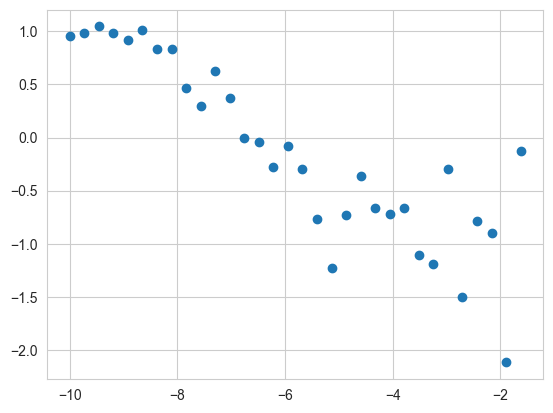

In [4]:
if h['dataset'] == 'RADIO':
    train_loader, val_loader, test_loader = get_radio_data_loaders(
        all_datasets_path=h['dataset_path'],
        batch_size=h['batch_size'],
        num_workers=h['num_workers'])
elif h['dataset'] == 'TOY_REGRESSION':
    train, val, test = get_toy_regression_data_loaders(
        batch_size=h['batch_size'],
        num_workers=h['num_workers'],
        num_points=500)
    train_loader, train_set = train
    val_loader, val_set = val
    test_loader, test_set = test

    x, y = next(iter(test_loader))
    plt.scatter(x, y)
    # x ticks
    plt.xticks(fontsize=10)
    plt.show()
else:
    raise ValueError(f"Unknown dataset: {h['dataset']}")

datamodule = DataModule(train_loader, val_loader, test_loader)

In [5]:
class CustomCallbacks(L.Callback):
    pass

#     def __init__(self, plot_every_n_epoch, num_pieces, wandb_logger: WandbLogger):
#         super().__init__()
#         self.plot_every_n_epoch = plot_every_n_epoch
#         self.num_pieces = num_pieces
#         self.wandb_logger = wandb_logger
# 
#     def assemble_image(self, pieces):
#         # pieces: [num_pieces, channels, height // num_pieces, width // num_pieces]
#         num_pieces, channels, piece_height, piece_width = pieces.shape
#         num_pieces_side = int(num_pieces ** 0.5)
# 
#         # Reshape to [num_pieces_side, num_pieces_side, channels, piece_height, piece_width]
#         pieces = pieces.view(num_pieces_side, num_pieces_side, channels, piece_height, piece_width)
# 
#         # Permute to [channels, num_pieces_side, piece_height, num_pieces_side, piece_width]
#         pieces = pieces.permute(2, 0, 3, 1, 4)
# 
#         # Reshape to [channels, height, width]
#         image = pieces.contiguous().view(channels, num_pieces_side * piece_height, num_pieces_side * piece_width)
# 
#         return image
# 
#     def log_images(self, trainer, pl_module, loader, prefix):
#         if (trainer.current_epoch % self.plot_every_n_epoch == 0) or (trainer.current_epoch == h['epochs'] - 1):
#             pl_module.eval()
#             image_batch, label_batch = next(iter(loader))
#             pieces, random_pieces, _ = batch_chunk_image(image_batch, self.num_pieces)
#             pieces, random_pieces = pieces.to(pl_module.device), random_pieces.to(pl_module.device)
# 
#             ordered_pieces, permutation_matrices = pl_module(random_pieces)
#             # Assemble the pieces into a single image before logging
#             nb_ims = min(ordered_pieces.shape[0], 10)
#             for i in range(nb_ims):
#                 initial_image = self.assemble_image(random_pieces[i])
#                 ordered_image = self.assemble_image(ordered_pieces[i])
#                 ground_truth_image = self.assemble_image(pieces[i])
# 
#                 # log to wandb
#                 self.wandb_logger.experiment.log(
#                     {f"{prefix}_predicted_image/img_{i}": wandb.Image(ordered_image.cpu().squeeze(),
#                                                                       caption=f"Label {label_batch[i]}"),
#                      f"{prefix}_ground_truth/img_{i}": wandb.Image(ground_truth_image.cpu().squeeze(),
#                                                                    caption=f"Label {label_batch[i]}"),
#                      f"{prefix}_input/img_{i}": wandb.Image(initial_image.cpu().squeeze(),
#                                                             caption=f"Label {label_batch[i]}")},
#                     step=trainer.global_step)
# 
#             pl_module.train()
# 
#     def on_train_epoch_end(self, trainer: pl.Trainer, pl_module: SinkhornConvNet):
#         self.log_images(trainer, pl_module, train_loader, "TRAIN")
# 
#     def on_validation_epoch_end(self, trainer: pl.Trainer, pl_module: SinkhornConvNet):
#         pass
# 
#     def on_train_end(self, trainer, pl_module):
#         self.log_images(trainer, pl_module, test_loader, "TEST_SET_train_end")


In [6]:
model = EnsembleNet(num_models=h['ensemble_size'])
if h['train']:
    if h['use_wandb']:
        date_identifier = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        wandb_logger = WandbLogger()
        wandb.init(project=h['wandb_project'],
                   config=h,
                   entity=h['wandb_entity'],
                   name=h['wandb_name'])

    trainer = L.Trainer(
        max_epochs=h['epochs'],
        # callbacks=[CustomCallbacks(plot_every_n_epoch=1, num_pieces=h['num_pieces'],
        #                            wandb_logger=wandb_logger)] if h['use_wandb'] else None,
        # logger=wandb_logger if h['use_wandb'] else None,
        limit_train_batches=h['limit_train_batches'],
        limit_val_batches=h['limit_val_batches'],
        limit_test_batches=h['limit_test_batches'],
        fast_dev_run=h['fast_dev_run'],
        overfit_batches=h['overfit_batches'],
        log_every_n_steps=10)

    # Train the model
    try:
        trainer.fit(model, datamodule)
    except KeyboardInterrupt:
        pass
    finally:  # Save the model even if the training was interrupted (only after keyboard interrupt)
        model.save()

    # Evaluate the model
    model = model.load()
    trainer.test(model, datamodule)

    # Finish the run if  it was running
    if wandb.run is not None:
        wandb.finish()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | models | ModuleList | 13.3 K
--------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

----------
In get_all_data: inputs_subset.shape = torch.Size([75, 1]), labels_subset.shape = torch.Size([75, 1])
----------
torch.Size([75, 1])
----------
In get_all_data: inputs_subset.shape = torch.Size([350, 1]), labels_subset.shape = torch.Size([350, 1])
----------


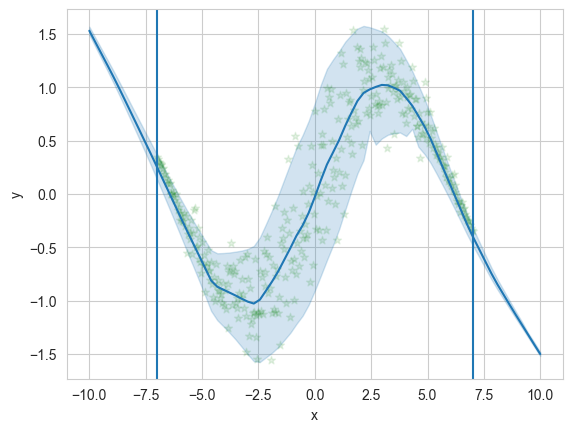

In [7]:
def make_plot_de(model: EnsembleNet, datamodule: DataModule, start, end):
    x_test, y_test = datamodule.get_all_data(datamodule.test_loader, subset_percentage=1.0)
    print(x_test.shape)
    mus, vars = model(x_test)

    # For epistemic uncertainty we calculate the std on the mus!
    means = mus.detach().numpy()
    stds = vars.detach().sqrt().numpy()

    dfs = []
    y_vals = [means, means + 2 * stds, means - 2 * stds]

    for i in range(3):
        data = {
            "x": list(x_test.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    x_train, y_train = datamodule.get_all_data(datamodule.train_loader, subset_percentage=1.0)
    scatter(x_train, y_train, c="green", marker="*", alpha=0.1)

    plt.show()


make_plot_de(model, datamodule, -7, 7)